In [39]:
library(ggplot2)
library(tidyverse)
library(janitor)
library(dplyr)
library(pROC)
library(caret)
library(nnet)

In [53]:
undersampling_data <- read.csv(file = "../data/undersampled_data.csv")
oversampling_data <- read.csv(file = "../data/oversampled_data.csv")
smote_data <- read.csv(file = "../data/smote_augmented_data_80_percent.csv")
cleaned_data <- read.csv(file = "../data/cleaned_data.csv")

In [54]:
process_data <- function(data) {
  # Clean column names
  data <- clean_names(data)
  
  # Hàm để phân loại BMI
  categorize_bmi <- function(bmi) {
    if (bmi < 18.5) {
      return('Underweight')
    } else if (bmi >= 18.5 & bmi < 24.9) {
      return('Normal weight')
    } else if (bmi >= 25 & bmi < 29.9) {
      return('Overweight')
    } else if (bmi >= 30 & bmi < 34.9) {
      return('Obesity class 1')
    } else if (bmi >= 35 & bmi < 39.9) {
      return('Obesity class 2')
    } else {
      return('Obesity class 3')
    }
  }
  
  # Tạo cột mới bmi_category cho dataframe data
  data$bmi_category <- sapply(data$bmi, categorize_bmi)
  # Chuyển đổi bmi_category thành factor với các levels cụ thể
  data$bmi_category <- factor(data$bmi_category, levels = c('Underweight', 'Normal weight', 'Overweight', 'Obesity class 1', 'Obesity class 2', 'Obesity class 3'))
  

  # Xóa các cột không cần thiết
  data <- within(data, rm("bmi", "ment_hlth"))
  
  # Chuyển đổi các biến không định lượng thành factor
  quantitative_vars <- c("phys_hlth")

  non_quantitative_vars <- setdiff(names(data), quantitative_vars)
  data[non_quantitative_vars] <- lapply(data[non_quantitative_vars], factor)

  # Chuyển đổi biến diabetes_012 thành 3 biến nhị phân
  data$is_diabetes <- as.numeric(data$diabetes_012 == 2)
  data$is_prediabetes <- as.numeric(data$diabetes_012 == 1)
  data$is_no_diabetes <- as.numeric(data$diabetes_012 == 0)

  # Sắp xếp lại cột
  other_cols <- setdiff(names(data), c("diabetes_012", "is_diabetes", "is_prediabetes", "is_no_diabetes"))
  data <- data[, c(other_cols, "diabetes_012", "is_diabetes", "is_prediabetes", "is_no_diabetes")]
  
  return(data)
}



In [55]:
undersampling_data <- process_data(undersampling_data)
oversampling_data <- process_data(oversampling_data)
smote_data <- process_data(smote_data)
cleaned_data <- process_data(cleaned_data)


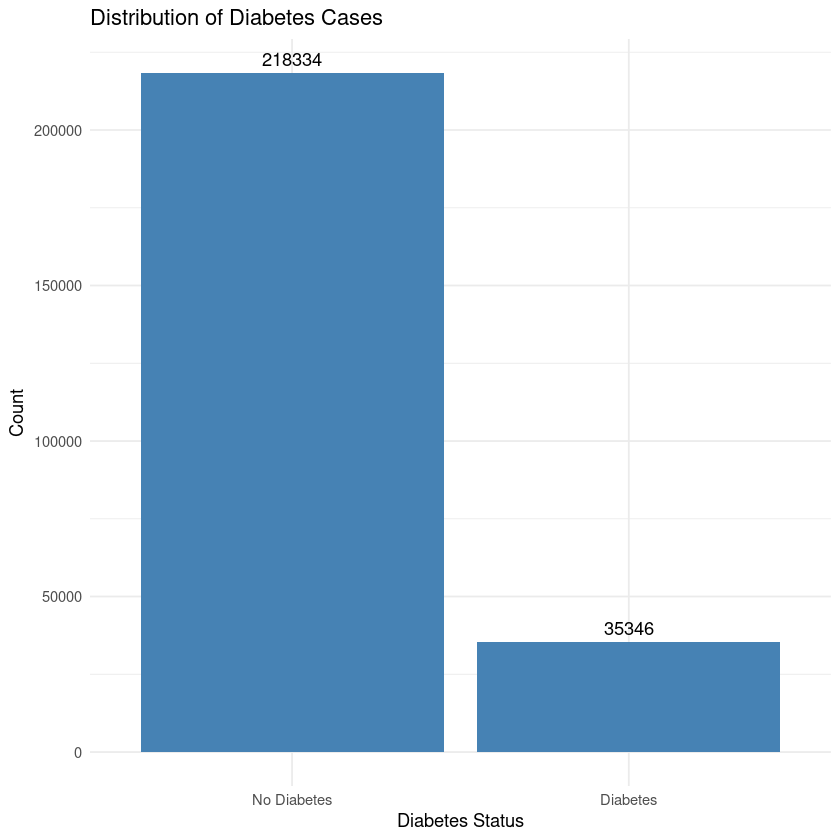

In [11]:
ggplot(cleaned_data, aes(x = factor(is_diabetes))) +
    geom_bar(fill = "steelblue") +
    geom_text(stat = 'count', aes(label = ..count..), vjust = -0.5) +
    labs(x = "Diabetes Status", y = "Count",
             title = "Distribution of Diabetes Cases") +
    scale_x_discrete(labels = c("No Diabetes", "Diabetes")) +
    theme_minimal()

In [13]:
library(ROSE)
set.seed(42)

# Use is_diabetes as the binary target variable
# Perform ROSE sampling
smote_balanced <- ROSE(is_diabetes ~ ., data = cleaned_data, seed = 42, N = nrow(cleaned_data), p = 0.5)$data

# Print class distribution after ROSE
table(smote_balanced$is_diabetes)


     0      1 
127077 126603 

In [20]:
# Undersampling
under_balanced <- ROSE(is_diabetes ~ ., data = cleaned_data, seed = 42, 
                      N = 2 * sum(cleaned_data$is_diabetes == 1), 
                      p = 0.5)$data

# Print class distribution after balancing
cat("Undersampling distribution:\n")
table(under_balanced$is_diabetes)

# Oversampling
over_balanced <- ROSE(is_diabetes ~ ., data = cleaned_data, seed = 42,
                     N = 2 * sum(cleaned_data$is_diabetes == 0),
                     p = 0.5)$data


cat("\nOversampling distribution:\n")
table(over_balanced$is_diabetes)

Undersampling distribution:



    0     1 
35228 35464 


Oversampling distribution:



     0      1 
218166 218502 

# Modeling

## Binary

In [14]:
set.seed(42) 

train_test_split <- function(data, train_ratio = 0.8) {
    train_indices <- sample(seq_len(nrow(data)), size = floor(train_ratio * nrow(data)), replace = FALSE)
    train_data <- data[train_indices, ]
    test_data <- data[-train_indices, ]
    res <- list(
        train_data = train_data,
        test_data = test_data
    )
    return(res)
}

In [ ]:
# List of datasets to evaluate
datasets <- list(
    "Original Data" = cleaned_data,
    "Oversampled Data" = over_balanced,
    "Undersampled Data" = under_balanced,
    "SMOTE Data" = smote_balanced
)

# Store results
results <- data.frame(
    Dataset = character(),
    Accuracy = numeric(),
    Sensitivity = numeric(),
    Specificity = numeric(),
    stringsAsFactors = FALSE
)

# Loop through each dataset
for (dataset_name in names(datasets)) {
    data <- datasets[[dataset_name]]
    label = "is_diabetes"
    
    # Split data
    train_data <- train_test_split(data)$train_data
    test_data <- train_test_split(data)$test_data
    
    # Define predictors
    predictors <- names(data)[!names(data) %in% 
                                   c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]
    
    # Create formula
    formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))
    
    # Fit model
    logistic_model <- glm(formula, data = train_data, family = "binomial")
    
    # Make predictions
    predictions_prob <- predict(logistic_model, newdata = test_data, type = "response")
    predictions <- ifelse(predictions_prob > 0.5, 1, 0)
    
    # Calculate metrics
    accuracy <- mean(predictions == test_data$is_diabetes)
    sensitivity <- sum(predictions == 1 & test_data$is_diabetes == 1) / sum(test_data$is_diabetes == 1)
    specificity <- sum(predictions == 0 & test_data$is_diabetes == 0) / sum(test_data$is_diabetes == 0)
    
    # Store results
    results <- rbind(results, data.frame(
        Dataset = dataset_name,
        Accuracy = round(accuracy, 4),
        Sensitivity = round(sensitivity, 4),
        Specificity = round(specificity, 4)
    ))
}
# Display results
print(results)

            Dataset Accuracy Sensitivity Specificity
1     Original Data   0.8659      0.1710      0.9782
2  Oversampled Data   0.7499      0.7808      0.7187
3 Undersampled Data   0.7460      0.7779      0.7139
4        SMOTE Data   0.7462      0.7736      0.7194


In [32]:
data = over_balanced
label = "is_diabetes"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- glm(formula, data = train_data, family = "binomial")
# summary(logistic_model)

predictions_prob <- predict(logistic_model, newdata = test_data, type = "response")
predictions <- ifelse(predictions_prob > 0.451404, 1, 0)

accuracy <- mean(predictions == test_data$is_diabetes)
print(paste("Model Accuracy:", round(accuracy, 4)))
# Calculate sensitivity and specificity
sensitivity <- sum(predictions == 1 & test_data$is_diabetes == 1) / sum(test_data$is_diabetes == 1)
specificity <- sum(predictions == 0 & test_data$is_diabetes == 0) / sum(test_data$is_diabetes == 0)

print(paste("Sensitivity:", round(sensitivity, 4)))
print(paste("Specificity:", round(specificity, 4)))

[1] "Model Accuracy: 0.7501"
[1] "Sensitivity: 0.8203"
[1] "Specificity: 0.6796"


Prediction,Reference,Freq
<fct>,<fct>,<int>
0,0,29611
1,0,13963
0,1,7865
1,1,35895


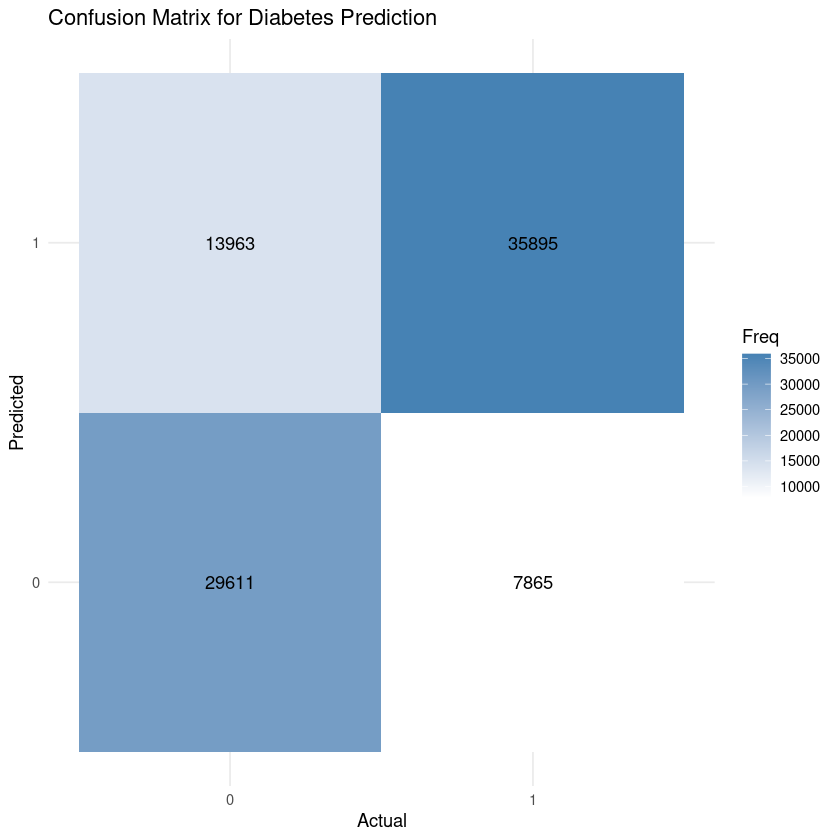

In [38]:
conf_matrix <- confusionMatrix(factor(predictions), factor(test_data$is_diabetes))

conf_data <- as.data.frame(conf_matrix$table)
conf_data
ggplot(conf_data, aes(x = Reference, y = Prediction)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for Diabetes Prediction",
             x = "Actual",
             y = "Predicted")

Setting levels: control = 0, case = 1

Setting direction: controls < cases



95% CI: 0.8241-0.8295 (DeLong)


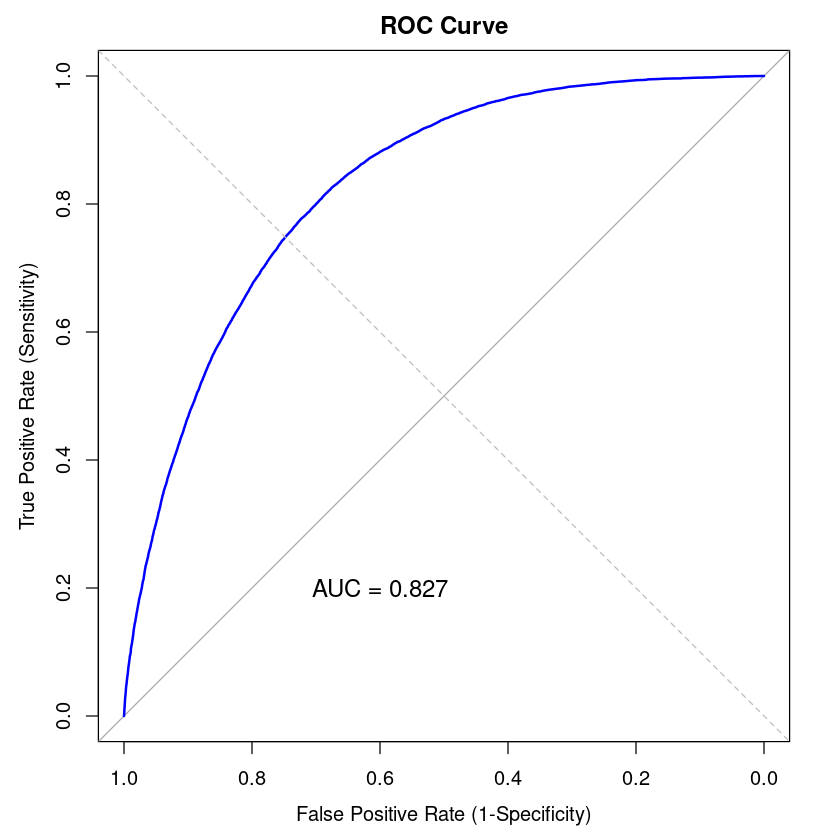

In [30]:
# Calculate ROC curve
roc_obj <- roc(test_data$is_diabetes, predictions_prob)
auc_value <- auc(roc_obj)
print(ci.auc(roc_obj,conf.level = 0.95))

# Plot ROC curve
plot(roc_obj, main = "ROC Curve",
    col = "blue", lwd = 2,
    xlab = "False Positive Rate (1-Specificity)",
    ylab = "True Positive Rate (Sensitivity)")
abline(a = 0, b = 1, lty = 2, col = "gray")

# Add AUC value to plot
text(0.6, 0.2, paste("AUC =", round(auc_value, 3)),
    col = "black", cex = 1.2)

In [31]:
# Lựa chọn ngưỡng tối ưu dựa trên phương pháp Youden Index
out_youd <- coords(roc_obj, "best", ret = c("threshold", "specificity", "sensitivity"),best.method = "youden")
print(out_youd)

  threshold specificity sensitivity
1  0.451404   0.6803762   0.8206406


In [33]:
out_youd <- coords(roc_obj, "best", ret = c("threshold", "specificity", "sensitivity"),best.method = "closest.topleft")
print(out_youd)

  threshold specificity sensitivity
1 0.5165103    0.734465   0.7641236


## Multiclass

In [67]:
data = undersampling_data
label = "diabetes_012"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- multinom(formula, data = train_data, maxit=1500)

# weights:  150 (98 variable)


initial  value 12209.976976 
iter  10 value 11161.583593
iter  20 value 10982.126312
iter  30 value 10676.500922
iter  40 value 10588.675653
iter  50 value 10523.751458
iter  60 value 10515.633853
iter  70 value 10513.229252
iter  80 value 10512.750165
iter  90 value 10512.373549
iter 100 value 10512.038708
final  value 10511.977668 
converged


$Precision
        0         1         2 
0.6125498 0.4553441 0.5219780 

$Recall
        0         1         2 
0.6612903 0.3402626 0.6096257 

$Accuracy
[1] 0.5383231

$Kappa
[1] 0.306849

$Macro_F1
[1] 0.5334848



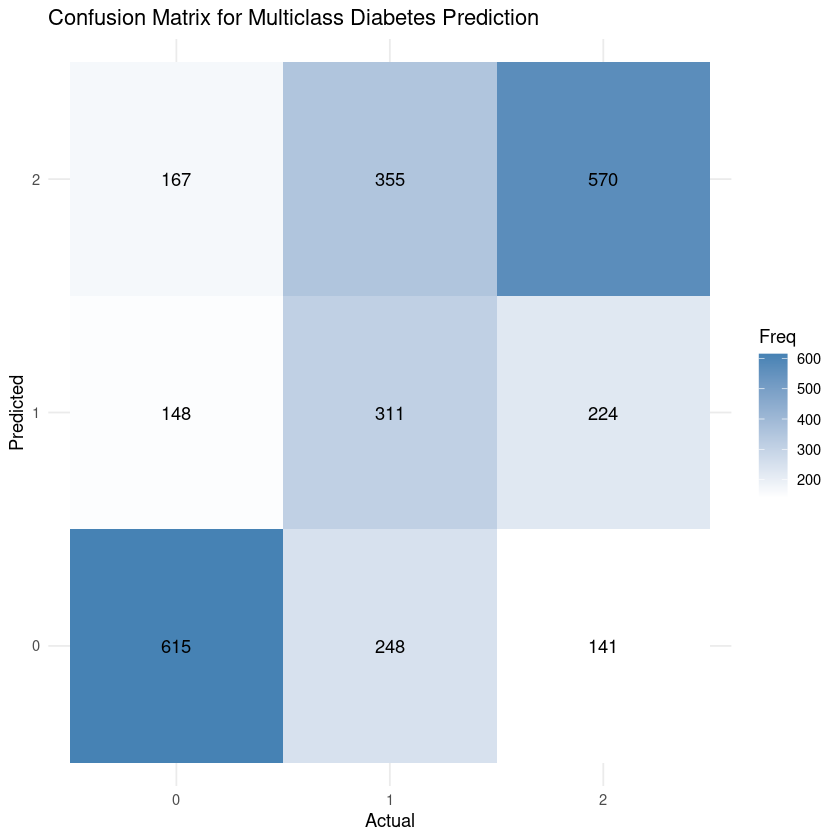

In [70]:
# Get predictions
predictions <- predict(logistic_model, newdata = test_data)

# Create confusion matrix
conf_matrix <- table(Actual = test_data$diabetes_012,Predicted = predictions)

# Define evaluation function for multiclass metrics
eval_metrics <- function(x) {
    cc <- sum(diag(x))
    sc <- sum(x)
    pp <- colSums(x)
    tt <- rowSums(x)
    
    # Calculate metrics
    prec <- diag(x)/colSums(x)
    recall <- diag(x)/rowSums(x)
    macro_prec <- mean(prec)
    macro_recall <- mean(recall)
    macro_f1 <- 2 * macro_prec * macro_recall/(macro_prec + macro_recall)
    acc <- cc/sc
    kap <- (cc * sc - sum(pp * tt))/(sc^2 - sum(pp * tt))
    
    return(list(
        Precision = prec,   
        Recall = recall,
        Accuracy = acc,
        Kappa = kap,
        Macro_F1 = macro_f1
    ))
}

# Calculate and display metrics
metrics <- eval_metrics(conf_matrix)
print(metrics)

# Visualize confusion matrix
conf_data <- as.data.frame(conf_matrix)
ggplot(conf_data, aes(x = Actual, y = Predicted)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for Multiclass Diabetes Prediction",
         x = "Actual",
         y = "Predicted")

In [76]:
data = oversampling_data
label = "diabetes_012"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- multinom(formula, data = train_data, maxit=1500)
summary(logistic_model)
# Get predictions
predictions <- predict(logistic_model, newdata = test_data)

# Create confusion matrix
conf_matrix <- table(Predicted = predictions, Actual = test_data$diabetes_012)


# weights:  150 (98 variable)
initial  value 488334.260924 
iter  10 value 437876.242760
iter  20 value 432706.236476
iter  30 value 432145.587183
iter  40 value 431385.755415
iter  50 value 428944.261891
iter  60 value 427101.428804
iter  70 value 421713.743532
iter  80 value 418559.860713
iter  90 value 417779.176771
iter 100 value 416612.725262
final  value 415640.972618 
converged


Call:
multinom(formula = formula, data = train_data, maxit = 1500)

Coefficients:
  (Intercept)  high_bp1 high_chol1 chol_check1     smoker1     stroke1
1   -4.380065 0.3337330  0.5700089   0.7990081 -0.02204392 -0.07076686
2   -5.927344 0.6964348  0.5837598   1.3263285 -0.03960621  0.17819220
  heart_diseaseor_attack1 phys_activity1     fruits1    veggies1
1             0.009376938    -0.02108166 -0.01874727 -0.05494826
2             0.268341520    -0.06773534 -0.02356051 -0.02557389
  hvy_alcohol_consump1 any_healthcare1 no_docbc_cost1 gen_hlth2 gen_hlth3
1           -0.1658359     -0.05467906      0.4016688 0.4779100 0.8590674
2           -0.8075777      0.06959641      0.1122018 0.7132962 1.4418408
  gen_hlth4 gen_hlth5    phys_hlth   diff_walk1       sex1      age2      age3
1  1.136393  1.004986  0.001310042 -0.009039965 0.09641377 0.5854793 0.4282749
2  1.893739  2.026697 -0.002235588  0.097858285 0.27612468 0.2660963 0.3671437
       age4      age5     age6     age7     age8   

Warning message in cc * sc:
“NAs produced by integer overflow”


$Precision
        0         1         2 
0.6103875 0.4241298 0.4891569 

$Recall
        0         1         2 
0.7198146 0.2519091 0.5802673 

$Accuracy
[1] 0.5321347

$Kappa
[1] NA

$Macro_F1
[1] 0.5125674



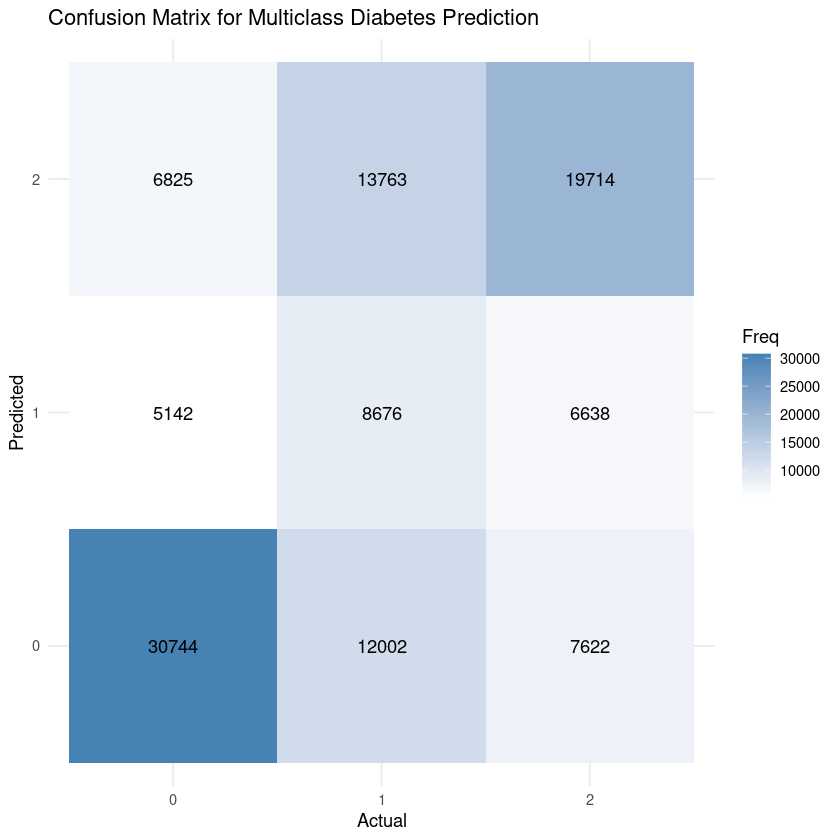

In [73]:
# Get predictions
predictions <- predict(logistic_model, newdata = test_data)

# Create confusion matrix
conf_matrix <- table(Actual = test_data$diabetes_012,Predicted=predictions)

# Define evaluation function for multiclass metrics
eval_metrics <- function(x) {
    cc <- sum(diag(x))
    sc <- sum(x)
    pp <- colSums(x)
    tt <- rowSums(x)
    
    # Calculate metrics
    prec <- diag(x)/colSums(x)
    recall <- diag(x)/rowSums(x)
    macro_prec <- mean(prec)
    macro_recall <- mean(recall)
    macro_f1 <- 2 * macro_prec * macro_recall/(macro_prec + macro_recall)
    acc <- cc/sc
    kap <- (cc * sc - sum(pp * tt))/(sc^2 - sum(pp * tt))
    
    return(list(
        Precision = prec,   
        Recall = recall,
        Accuracy = acc,
        Kappa = kap,
        Macro_F1 = macro_f1
    ))
}

# Calculate and display metrics
metrics <- eval_metrics(conf_matrix)
print(metrics)

# Visualize confusion matrix
conf_data <- as.data.frame(conf_matrix)
ggplot(conf_data, aes(x = Actual, y = Predicted)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for Multiclass Diabetes Prediction",
         x = "Actual",
         y = "Predicted")


# weights:  150 (98 variable)
initial  value 222956.772313 
iter  10 value 120057.313592
iter  20 value 116634.122756
iter  30 value 105995.332813
iter  40 value 101900.703739
iter  50 value 98420.740945
iter  60 value 87967.575637
iter  70 value 85591.467715
iter  80 value 84084.458592
iter  90 value 81390.415363
iter 100 value 80467.631613
iter 110 value 80203.988950
final  value 80202.894411 
converged


Warning message in cc * sc:
“NAs produced by integer overflow”


$Precision
        0         1         2 
0.9755234 0.0000000 0.1894471 

$Recall
        0         1         2 
0.8623270       NaN 0.5434783 

$Accuracy
[1] 0.8467163

$Kappa
[1] NA

$Macro_F1
[1] NaN



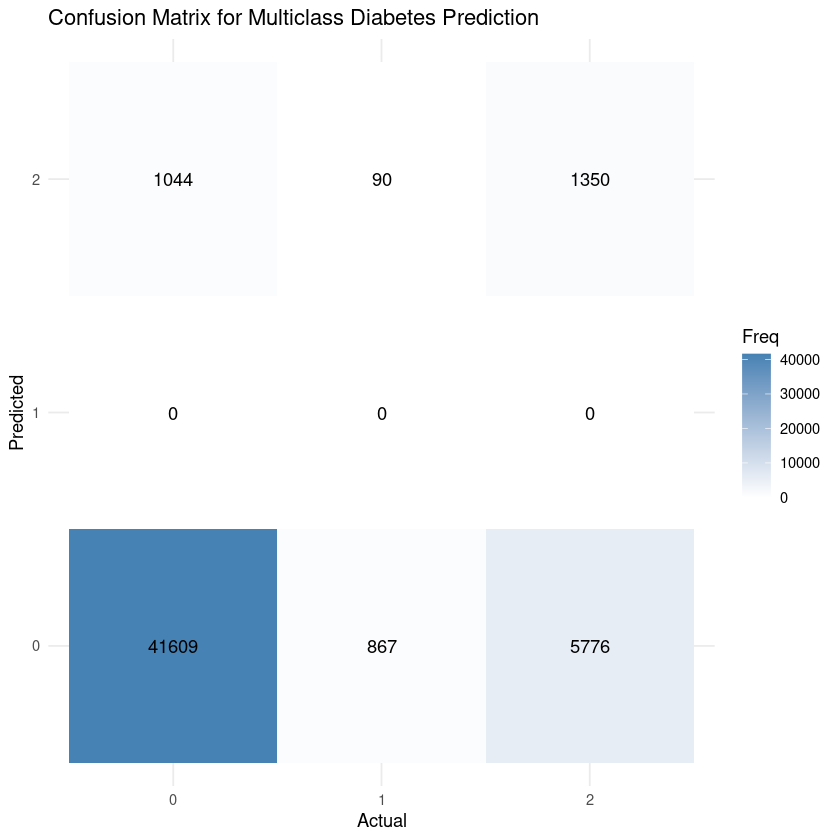

In [75]:
data = cleaned_data
label = "diabetes_012"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- multinom(formula, data = train_data, maxit=1500)
# Get predictions
predictions <- predict(logistic_model, newdata = test_data)

# Create confusion matrix
conf_matrix <- table(Predicted = predictions, Actual = test_data$diabetes_012)

# Define evaluation function
eval_metrics <- function(x) {
    cc <- sum(diag(x))
    sc <- sum(x)
    pp <- colSums(x)
    tt <- rowSums(x)
    
    # Calculate metrics
    prec <- diag(x)/colSums(x)
    recall <- diag(x)/rowSums(x)
    macro_prec <- mean(prec)
    macro_recall <- mean(recall)
    macro_f1 <- 2 * macro_prec * macro_recall/(macro_prec + macro_recall)
    acc <- cc/sc
    kap <- (cc * sc - sum(pp * tt))/(sc^2 - sum(pp * tt))
    
    return(list(
        Precision = prec,   
        Recall = recall,
        Accuracy = acc,
        Kappa = kap,
        Macro_F1 = macro_f1
    ))
}

# Calculate and display metrics
metrics <- eval_metrics(conf_matrix)
print(metrics)

# Visualize confusion matrix
conf_data <- as.data.frame(conf_matrix)
ggplot(conf_data, aes(x = Actual, y = Predicted)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for Multiclass Diabetes Prediction",
         x = "Actual",
         y = "Predicted")


In [58]:
data = cleaned_data
label = "diabetes_012"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- multinom(formula, data = train_data, maxit=1500)
# Get predictions
predictions <- predict(logistic_model, newdata = test_data)

# Create confusion matrix
conf_matrix <- table(test_data$diabetes_012, predictions)
conf_matrix


# weights:  150 (98 variable)
initial  value 222956.772313 
iter  10 value 119990.712785
iter  20 value 116353.582397
iter  30 value 105721.834979
iter  40 value 101873.585763
iter  50 value 97531.809735
iter  60 value 86440.781432
iter  70 value 84666.576730
iter  80 value 83280.921838
iter  90 value 81450.272797
iter 100 value 80620.034208
iter 110 value 80368.397874
final  value 80365.285542 
converged


   predictions
        0     1     2
  0 41662     0  1016
  1   851     0    87
  2  5749     0  1371